In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.constraints import MinMaxNorm, MaxNorm
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping

from scipy.stats.stats import pearsonr

from google.colab import drive
drive.mount('/content/gdrive')

<ipython-input-1-3138ec756819>:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


Mounted at /content/gdrive


In [2]:
# df8 = pd.read_csv("8dec.csv")
# df17 = pd.read_csv("17dec.csv")
# df817 = pd.read_csv("8dec17dec.csv")
# df321 = pd.read_csv("3dec21dec.csv")
from google.colab import files
uploaded = files.upload()

dfrabitrain= pd.read_csv("Rabi_train - Sheet1.csv")
dfrabitest= pd.read_csv("Rabi_test - Sheet1.csv")
df817 = pd.read_csv("8dec17dec - Sheet1.csv")
df321 = pd.read_csv("3dec21dec - Sheet1.csv")

from pathlib import Path
image_dir= Path("/content/gdrive/MyDrive/AYUSHH/Xtest8dec17dec")
# image_dir= Path("Xtest8dec17dec")
filepaths_1 = pd.Series(list(image_dir.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_1 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_1]
sorted_filepaths_1 = [x for _, x in sorted(zip(numeric_parts_1, filepaths_1))]
filepaths_series_1 = pd.Series(sorted_filepaths_1, name='Filepath')
bmass_1 = df817['Biomass']
images_1 =  pd.concat([filepaths_series_1,bmass_1],axis=1)

image_dir_4= Path("/content/gdrive/MyDrive/AYUSHH/Rabi22_23_Test")
filepaths_4 = pd.Series(list(image_dir_4.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_4 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_4]
sorted_filepaths_4 = [x for _, x in sorted(zip(numeric_parts_4, filepaths_4))]
filepaths_series_4 = pd.Series(sorted_filepaths_4, name='Filepath')
bmass_4 = dfrabitest['Biomass']
images_4 = pd.concat([filepaths_series_4,bmass_4],axis=1)

test_images = pd.concat([images_1, images_4], ignore_index=True)


image_dir_3= Path("/content/gdrive/MyDrive/AYUSHH/Xtrain3dec21dec")
# image_dir_3= Path("Xtrain3dec21dec")
filepaths_3 = pd.Series(list(image_dir_3.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_3 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_3]
sorted_filepaths_3 = [x for _, x in sorted(zip(numeric_parts_3, filepaths_3))]
filepaths_series_3 = pd.Series(sorted_filepaths_3, name='Filepath')
bmass_3 = df321['Biomass']
images_3 = pd.concat([filepaths_series_3,bmass_3],axis=1)

image_dir_2= Path("/content/gdrive/MyDrive/AYUSHH/rabi_22_23data")
filepaths_2 = pd.Series(list(image_dir_2.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_2 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_2]
sorted_filepaths_2 = [x for _, x in sorted(zip(numeric_parts_2, filepaths_2))]
filepaths_series_2 = pd.Series(sorted_filepaths_2, name='Filepath')
bmass_2 = dfrabitrain['Biomass']
images_2 = pd.concat([filepaths_series_2,bmass_2],axis=1)

train_images = pd.concat([images_2, images_3], ignore_index=True)

Saving 3dec21dec - Sheet1.csv to 3dec21dec - Sheet1.csv
Saving 8dec17dec - Sheet1.csv to 8dec17dec - Sheet1.csv
Saving Rabi_test - Sheet1.csv to Rabi_test - Sheet1.csv
Saving Rabi_train - Sheet1.csv to Rabi_train - Sheet1.csv


Robust, Augmentation

In [12]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_images['Biomass'] = scaler.fit_transform(train_images['Biomass'].values.reshape(-1, 1))  # leanrt u and sigma for train data

train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator( # data_gen object -- in parameters ke according iamge par operation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_data = train_generator_aug.flow_from_dataframe(      #6D --- (5D,2D) tensor ( #batches and other 4)
    dataframe=train_images,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512), # why use this?
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,   # small batch size -- noisier gradient descent
    shuffle=True,
    seed=42,
    subset='training'
)
# X_train, y_train = next(train_data)   # batch data
# X_train2,y_train2= train_images       # too much data to unpack

val_data = train_generator_aug.flow_from_dataframe(
    dataframe=train_images,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)
# X_val, y_val = next(val_images)

test_data = test_generator_aug.flow_from_dataframe(
    dataframe=images_4,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=2,
    shuffle=False
)

test_data2 = test_generator_aug.flow_from_dataframe(
    dataframe=images_1,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=2,
    shuffle=False
)
# X_test, y_test = next(test_images)
# X_test shape is 2,512,512,3
# y_test shape is (2,)

Found 231 validated image filenames.
Found 57 validated image filenames.
Found 72 validated image filenames.
Found 108 validated image filenames.


In [ ]:
import tensorflow as tf
from keras.applications import VGG16

# Load VGG16 model without top (fully connected layers)
base_model = VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

# Print model summary
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

Epoch 1/90
58/58 [==============================] - 145s 2s/step - loss: 0.5941 - mae: 0.6145 - root_mean_squared_error: 0.7708 - val_loss: 0.2756 - val_mae: 0.5093 - val_root_mean_squared_error: 0.5250
Epoch 2/90
58/58 [==============================] - 41s 708ms/step - loss: 0.4291 - mae: 0.5305 - root_mean_squared_error: 0.6551 - val_loss: 0.4357 - val_mae: 0.6449 - val_root_mean_squared_error: 0.6601
Epoch 3/90
58/58 [==============================] - 45s 782ms/step - loss: 0.2357 - mae: 0.3738 - root_mean_squared_error: 0.4855 - val_loss: 0.2589 - val_mae: 0.4873 - val_root_mean_squared_error: 0.5088
Epoch 4/90
58/58 [==============================] - 44s 755ms/step - loss: 0.2323 - mae: 0.3682 - root_mean_squared_error: 0.4820 - val_loss: 0.1844 - val_mae: 0.4010 - val_root_mean_squared_error: 0.4294
Epoch 5/90
58/58 [==============================] - 41s 705ms/step - loss: 0.2184 - mae: 0.3600 - root_mean_squared_error: 0.4673 - val_loss: 0.2173 - val_mae: 0.4404 - val_root_mean

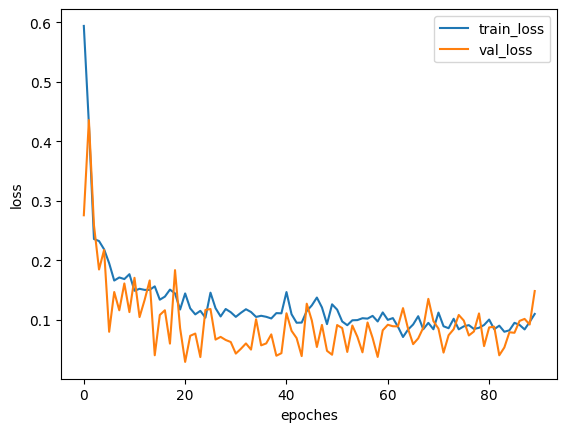

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=90,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
vvxnfn

In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/__New_Work__/vgg16yesrobust.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


In [4]:
model_path = '/content/gdrive/MyDrive/AYUSHH/__New_Work__/vgg16yesrobust.h5'
model2 = tf.keras.models.load_model(model_path)

36/36 [==============================] - 8s 214ms/step
Test dataset prediction - Rabi
euqation of line is : y=[0.0012622]*x + [0.41795027]
r2 score= 0.722
mae=412.581
mse=303,061.443
rmse=550.510


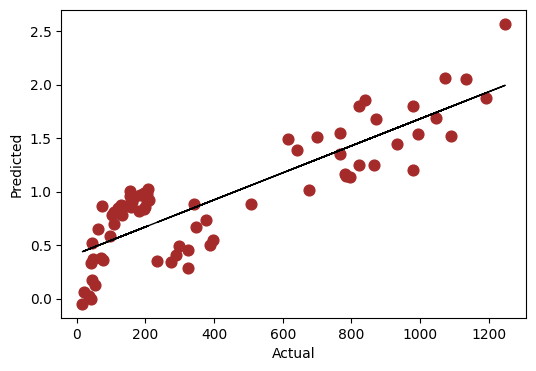

In [13]:
Pred= model2.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = images_4['Biomass'].values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - Rabi")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))

In [ ]:
scaler.inverse_transform(Pred)

54/54 [==============================] - 14s 254ms/step
Test dataset prediction - Sorghum
euqation of line is : y=[0.00161391]*x + [0.01287405]
r2 score= 0.812
mae=350.183
mse=202,970.251
rmse=450.522


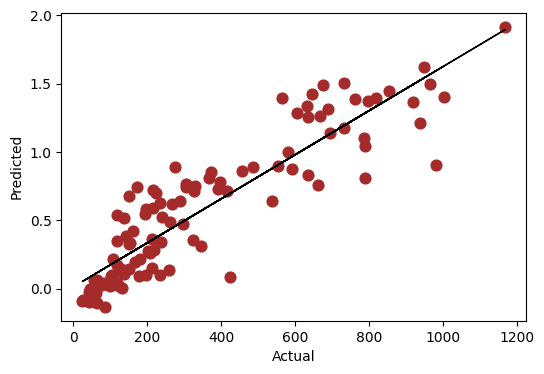

In [14]:
Pred= model2.predict(test_data2)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = images_1['Biomass'].values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - Sorghum")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))